In [222]:
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
from prophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

import seaborn as sns

from tqdm.auto import tqdm

import os

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)


DATA_FOLDER = '/home/jeronimo/Desktop/Freshflow_techChallenge/store_sales_forecasting/data'

In [2]:
dtype_map = {'id':str, 'date':str, 'store_nbr':str, 'family':str,
             'sales':float, 'onpromotion':int}
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'), dtype=dtype_map)
train.drop('id', axis=1, inplace=True)
train['date'] = pd.to_datetime(train.date, errors='coerce', format='%Y-%m-%d')

print(train.shape)
train.head()

(3000888, 5)


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [30]:
family_salesPerc = train[train.sales>0].groupby('family').sales.sum().sort_values(ascending=False)
family_salesPerc = family_salesPerc/family_salesPerc.sum()
family_salesPerc = family_salesPerc.reset_index()
family_salesPerc['cumulative_sales'] = family_salesPerc.sales.cumsum()
# Lets build a more sophisticated model only for these categories, which accound almost for 80% of sales
family_salesPerc.head()

,family,sales,cumulative_sales
0,GROCERY I,0.319903,0.319903
1,BEVERAGES,0.202073,0.521976
2,PRODUCE,0.114288,0.636264
3,CLEANING,0.090832,0.727096
4,DAIRY,0.060064,0.787161


In [59]:
train_families = train[train.family.isin(['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING', 'DAIRY'])]
print(train_families.shape)
train_families.head()

(454680, 5)


,date,store_nbr,family,sales,onpromotion
3,2013-01-01,1,BEVERAGES,0.0,0
7,2013-01-01,1,CLEANING,0.0,0
8,2013-01-01,1,DAIRY,0.0,0
12,2013-01-01,1,GROCERY I,0.0,0
30,2013-01-01,1,PRODUCE,0.0,0


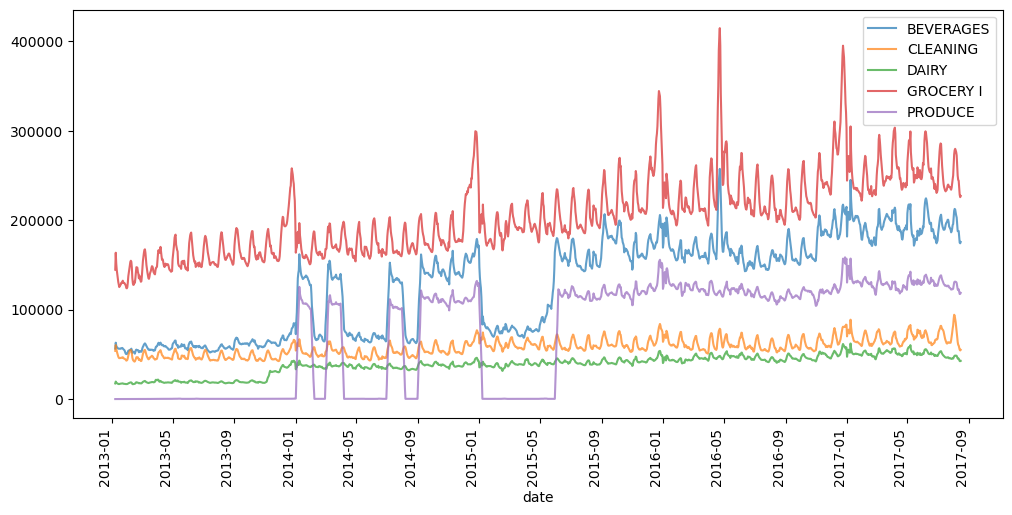

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))

family_sales = train_families.groupby(['date', 'family'], as_index=False).sales.sum().set_index('date')

for idx, g in family_sales.groupby('family'):
    g['sales_rolling'] = g.sales.rolling(7).mean()
    g.plot(y='sales_rolling', ax=ax, label=idx, alpha=0.7)

# show every 4th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=90)
plt.show()

Produce and beverages look very weird in some periods. I have no clue what could be related to the big dip at the beginning of 2015, or the beginning of the recorded data, but I feel that most likely it is related to missing information.

In [61]:
family_sales[(family_sales.family=='PRODUCE') & (family_sales.sales<1000)]

,family,sales
date,,
2013-01-01,PRODUCE,0.0
2013-01-02,PRODUCE,0.0
2013-01-03,PRODUCE,0.0
2013-01-04,PRODUCE,0.0
2013-01-05,PRODUCE,0.0
...,...,...
2015-05-27,PRODUCE,74.0
2015-05-28,PRODUCE,103.0
2015-05-29,PRODUCE,363.0


I am going to create one prophet model per family and per store only for the families in train_families. I will use all the dates for GROCERY I, DAIRY and CLEANING. For PRODUCE and BEVERAGES I will use from 2015-06-01.

# GROCERY I model

In [98]:
def setup_prophetData(data, y_col, ds_col):
    if y_col is not None:
        prophetData = data[[ds_col, y_col]].rename({y_col:'y', ds_col:'ds'}, axis=1)
    else:
        prophetData = data[[ds_col]].rename({ds_col:'ds'}, axis=1)
        
    return prophetData

In [171]:
def RMSLE(y, yhat):
    metric = (np.log(1+yhat) - np.log(1+y))**2
    return np.sqrt(metric.mean())

In [223]:
def train_prophet(idx, g, val_df):
    m = Prophet(growth='linear')
    train_df = setup_prophetData(g, 'sales', 'date')
    m.fit(train_df)

    val_dates = setup_prophetData(val_df[val_df.store_nbr==idx], 'sales', 'date')
    forecast = m.predict(val_dates)

    val_df = pd.merge(forecast, val_dates, on='ds')
    err = round(RMSLE(val_df.y, val_df.yhat), 2)
    print('Val RMSLE: ', err)
    
    all_data = pd.concat([train_df[['ds', 'y']], val_df[['ds', 'y']]])
    
    # fit to all data in the end
    m = Prophet(growth='linear')
    m.fit(all_data)
    
    return m, err

In [199]:
dtype_map = {'id':str, 'date':str, 'store_nbr':str, 'family':str,
             'sales':float, 'onpromotion':int}
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'), dtype=dtype_map)
# test.drop('id', axis=1, inplace=True)
test['date'] = pd.to_datetime(test.date, errors='coerce', format='%Y-%m-%d')
test = test[test.family=='GROCERY I']

print(test.shape)
test.head()

(864, 5)


,id,date,store_nbr,family,onpromotion
12,3000900,2017-08-16,1,GROCERY I,64
45,3000933,2017-08-16,10,GROCERY I,96
78,3000966,2017-08-16,11,GROCERY I,102
111,3000999,2017-08-16,12,GROCERY I,87
144,3001032,2017-08-16,13,GROCERY I,90


In [200]:
grocery_data = train_families[train_families.family=='GROCERY I']
grocery_data['weekday'] = grocery_data.date.dt.weekday

print(grocery_data.shape)
grocery_data.head()

(90936, 6)


,date,store_nbr,family,sales,onpromotion,weekday
12,2013-01-01,1,GROCERY I,0.0,0,1
45,2013-01-01,10,GROCERY I,0.0,0,1
78,2013-01-01,11,GROCERY I,0.0,0,1
111,2013-01-01,12,GROCERY I,0.0,0,1
144,2013-01-01,13,GROCERY I,0.0,0,1


In [201]:
max_date = grocery_data.date.max() - pd.DateOffset(15)

# set up internal train and validation sets
grocery_train = grocery_data[grocery_data.date<max_date]
grocery_val = grocery_data[grocery_data.date>=max_date]

In [224]:
worst_stores = []
pred_df = []

c=0
for i, g in tqdm(grocery_train.groupby('store_nbr')):
    m, err = train_prophet(i, g, grocery_val)
    
    g_test = test[test.store_nbr==i]
    g_test = setup_prophetData(g_test, None, 'date')
    
    forecast = m.predict(g_test)
    pred = forecast[['ds', 'yhat']].rename({'ds':'date', 'yhat':'sales'}, axis=1)
    pred['store_nbr'] = i

    pred_df.append(pred)
    
    if err > 0.3:
        worst_stores.append([i, err])
        
pred_df = pd.merge(test, pd.concat(pred_df), on=['date', 'store_nbr'], how='outer')

  0%|          | 0/54 [00:00<?, ?it/s]

15:03:04 - cmdstanpy - INFO - Chain [1] start processing
15:03:04 - cmdstanpy - INFO - Chain [1] done processing
15:03:04 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.26


15:03:05 - cmdstanpy - INFO - Chain [1] done processing
15:03:06 - cmdstanpy - INFO - Chain [1] start processing
15:03:06 - cmdstanpy - INFO - Chain [1] done processing
15:03:06 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.23


15:03:06 - cmdstanpy - INFO - Chain [1] done processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] done processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:07 - cmdstanpy - INFO - Chain [1] done processing
15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] done processing
15:03:09 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.18


15:03:09 - cmdstanpy - INFO - Chain [1] done processing
15:03:09 - cmdstanpy - INFO - Chain [1] start processing
15:03:10 - cmdstanpy - INFO - Chain [1] done processing
15:03:10 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:10 - cmdstanpy - INFO - Chain [1] done processing
15:03:11 - cmdstanpy - INFO - Chain [1] start processing
15:03:11 - cmdstanpy - INFO - Chain [1] done processing
15:03:11 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.26


15:03:11 - cmdstanpy - INFO - Chain [1] done processing
15:03:12 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing
15:03:13 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.17


15:03:13 - cmdstanpy - INFO - Chain [1] done processing
15:03:14 - cmdstanpy - INFO - Chain [1] start processing
15:03:14 - cmdstanpy - INFO - Chain [1] done processing
15:03:14 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.21


15:03:14 - cmdstanpy - INFO - Chain [1] done processing
15:03:15 - cmdstanpy - INFO - Chain [1] start processing
15:03:15 - cmdstanpy - INFO - Chain [1] done processing
15:03:15 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.14


15:03:16 - cmdstanpy - INFO - Chain [1] done processing
15:03:16 - cmdstanpy - INFO - Chain [1] start processing
15:03:16 - cmdstanpy - INFO - Chain [1] done processing
15:03:17 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:03:17 - cmdstanpy - INFO - Chain [1] done processing
15:03:17 - cmdstanpy - INFO - Chain [1] start processing
15:03:18 - cmdstanpy - INFO - Chain [1] done processing
15:03:18 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.12


15:03:18 - cmdstanpy - INFO - Chain [1] done processing
15:03:19 - cmdstanpy - INFO - Chain [1] start processing
15:03:19 - cmdstanpy - INFO - Chain [1] done processing
15:03:20 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.17


15:03:20 - cmdstanpy - INFO - Chain [1] done processing
15:03:20 - cmdstanpy - INFO - Chain [1] start processing
15:03:21 - cmdstanpy - INFO - Chain [1] done processing
15:03:21 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.33


15:03:21 - cmdstanpy - INFO - Chain [1] done processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] done processing
15:03:22 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.24


15:03:22 - cmdstanpy - INFO - Chain [1] done processing
15:03:23 - cmdstanpy - INFO - Chain [1] start processing
15:03:23 - cmdstanpy - INFO - Chain [1] done processing
15:03:24 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:03:24 - cmdstanpy - INFO - Chain [1] done processing
15:03:24 - cmdstanpy - INFO - Chain [1] start processing
15:03:25 - cmdstanpy - INFO - Chain [1] done processing
15:03:25 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.12


15:03:25 - cmdstanpy - INFO - Chain [1] done processing
15:03:26 - cmdstanpy - INFO - Chain [1] start processing
15:03:26 - cmdstanpy - INFO - Chain [1] done processing
15:03:26 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:27 - cmdstanpy - INFO - Chain [1] done processing
15:03:28 - cmdstanpy - INFO - Chain [1] start processing
15:03:28 - cmdstanpy - INFO - Chain [1] done processing
15:03:28 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:28 - cmdstanpy - INFO - Chain [1] done processing
15:03:29 - cmdstanpy - INFO - Chain [1] start processing
15:03:29 - cmdstanpy - INFO - Chain [1] done processing
15:03:29 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.32


15:03:30 - cmdstanpy - INFO - Chain [1] done processing
15:03:30 - cmdstanpy - INFO - Chain [1] start processing
15:03:30 - cmdstanpy - INFO - Chain [1] done processing
15:03:31 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.16


15:03:31 - cmdstanpy - INFO - Chain [1] done processing
15:03:31 - cmdstanpy - INFO - Chain [1] start processing
15:03:31 - cmdstanpy - INFO - Chain [1] done processing
15:03:32 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.29


15:03:32 - cmdstanpy - INFO - Chain [1] done processing
15:03:32 - cmdstanpy - INFO - Chain [1] start processing
15:03:33 - cmdstanpy - INFO - Chain [1] done processing
15:03:33 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.18


15:03:33 - cmdstanpy - INFO - Chain [1] done processing
15:03:34 - cmdstanpy - INFO - Chain [1] start processing
15:03:35 - cmdstanpy - INFO - Chain [1] done processing
15:03:35 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.15


15:03:35 - cmdstanpy - INFO - Chain [1] done processing
15:03:36 - cmdstanpy - INFO - Chain [1] start processing
15:03:36 - cmdstanpy - INFO - Chain [1] done processing
15:03:36 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.26


15:03:36 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:38 - cmdstanpy - INFO - Chain [1] start processing
15:03:38 - cmdstanpy - INFO - Chain [1] done processing
15:03:39 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:39 - cmdstanpy - INFO - Chain [1] done processing
15:03:39 - cmdstanpy - INFO - Chain [1] start processing
15:03:39 - cmdstanpy - INFO - Chain [1] done processing
15:03:40 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.18


15:03:40 - cmdstanpy - INFO - Chain [1] done processing
15:03:40 - cmdstanpy - INFO - Chain [1] start processing
15:03:40 - cmdstanpy - INFO - Chain [1] done processing
15:03:41 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.11


15:03:42 - cmdstanpy - INFO - Chain [1] done processing
15:03:42 - cmdstanpy - INFO - Chain [1] start processing
15:03:42 - cmdstanpy - INFO - Chain [1] done processing
15:03:42 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.19


15:03:43 - cmdstanpy - INFO - Chain [1] done processing
15:03:43 - cmdstanpy - INFO - Chain [1] start processing
15:03:43 - cmdstanpy - INFO - Chain [1] done processing
15:03:44 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.17


15:03:44 - cmdstanpy - INFO - Chain [1] done processing
15:03:44 - cmdstanpy - INFO - Chain [1] start processing
15:03:45 - cmdstanpy - INFO - Chain [1] done processing
15:03:45 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:45 - cmdstanpy - INFO - Chain [1] done processing
15:03:45 - cmdstanpy - INFO - Chain [1] start processing
15:03:46 - cmdstanpy - INFO - Chain [1] done processing
15:03:46 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:46 - cmdstanpy - INFO - Chain [1] done processing
15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:48 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:03:48 - cmdstanpy - INFO - Chain [1] done processing
15:03:49 - cmdstanpy - INFO - Chain [1] start processing
15:03:49 - cmdstanpy - INFO - Chain [1] done processing
15:03:50 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.21


15:03:50 - cmdstanpy - INFO - Chain [1] done processing
15:03:50 - cmdstanpy - INFO - Chain [1] start processing
15:03:50 - cmdstanpy - INFO - Chain [1] done processing
15:03:51 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:03:51 - cmdstanpy - INFO - Chain [1] done processing
15:03:51 - cmdstanpy - INFO - Chain [1] start processing
15:03:51 - cmdstanpy - INFO - Chain [1] done processing
15:03:52 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.21


15:03:52 - cmdstanpy - INFO - Chain [1] done processing
15:03:52 - cmdstanpy - INFO - Chain [1] start processing
15:03:53 - cmdstanpy - INFO - Chain [1] done processing
15:03:53 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.24


15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:54 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.13


15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.18


15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1] done processing
15:03:57 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.16


15:03:58 - cmdstanpy - INFO - Chain [1] done processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] done processing
15:03:59 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.22


15:03:59 - cmdstanpy - INFO - Chain [1] done processing
15:03:59 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] done processing
15:04:00 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.2


15:04:00 - cmdstanpy - INFO - Chain [1] done processing
15:04:00 - cmdstanpy - INFO - Chain [1] start processing
15:04:00 - cmdstanpy - INFO - Chain [1] done processing
15:04:01 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.24


15:04:01 - cmdstanpy - INFO - Chain [1] done processing
15:04:02 - cmdstanpy - INFO - Chain [1] start processing
15:04:02 - cmdstanpy - INFO - Chain [1] done processing
15:04:02 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.16


15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.13


15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] start processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:05 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.15


15:04:05 - cmdstanpy - INFO - Chain [1] done processing
15:04:05 - cmdstanpy - INFO - Chain [1] start processing
15:04:05 - cmdstanpy - INFO - Chain [1] done processing
15:04:06 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.14


15:04:06 - cmdstanpy - INFO - Chain [1] done processing
15:04:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:07 - cmdstanpy - INFO - Chain [1] done processing
15:04:07 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.19


15:04:07 - cmdstanpy - INFO - Chain [1] done processing
15:04:08 - cmdstanpy - INFO - Chain [1] start processing
15:04:08 - cmdstanpy - INFO - Chain [1] done processing
15:04:09 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.16


15:04:09 - cmdstanpy - INFO - Chain [1] done processing
15:04:10 - cmdstanpy - INFO - Chain [1] start processing
15:04:10 - cmdstanpy - INFO - Chain [1] done processing
15:04:10 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.16


15:04:11 - cmdstanpy - INFO - Chain [1] done processing
15:04:11 - cmdstanpy - INFO - Chain [1] start processing
15:04:11 - cmdstanpy - INFO - Chain [1] done processing
15:04:12 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.15


15:04:12 - cmdstanpy - INFO - Chain [1] done processing
15:04:12 - cmdstanpy - INFO - Chain [1] start processing
15:04:12 - cmdstanpy - INFO - Chain [1] done processing
15:04:13 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.15


15:04:13 - cmdstanpy - INFO - Chain [1] done processing
15:04:13 - cmdstanpy - INFO - Chain [1] start processing
15:04:13 - cmdstanpy - INFO - Chain [1] done processing
15:04:14 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.14


15:04:14 - cmdstanpy - INFO - Chain [1] done processing
15:04:14 - cmdstanpy - INFO - Chain [1] start processing
15:04:15 - cmdstanpy - INFO - Chain [1] done processing
15:04:16 - cmdstanpy - INFO - Chain [1] start processing


Val RMSLE:  0.23


15:04:16 - cmdstanpy - INFO - Chain [1] done processing


## Model assessment

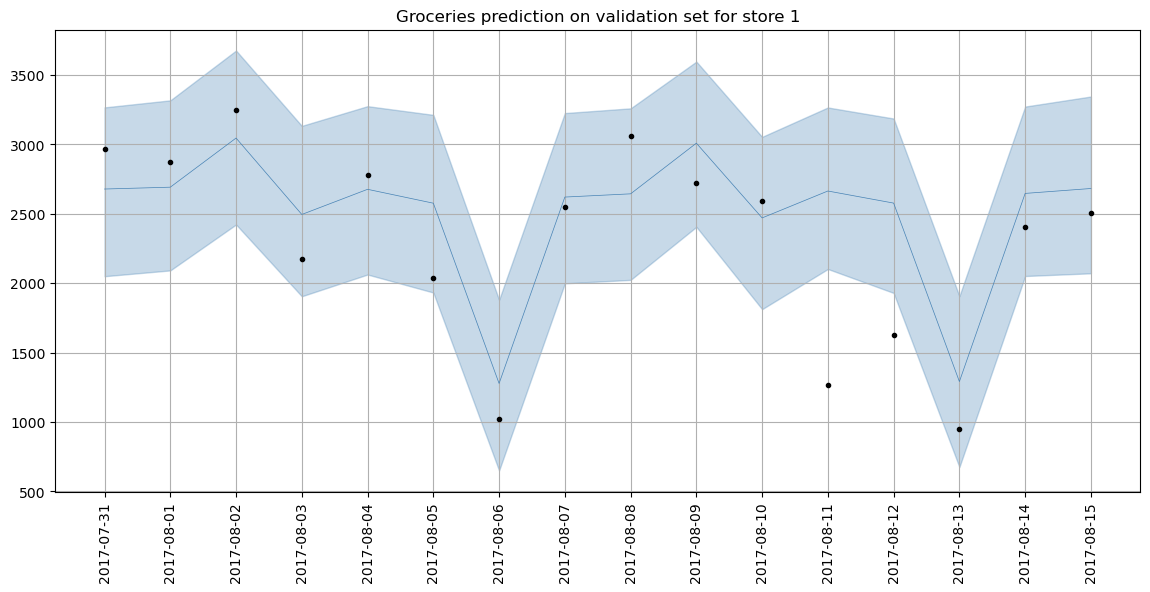

In [181]:
f, ax = plt.subplots(figsize=(14, 6))

ax.plot(val_df.ds, val_df.y, 'ko', markersize=3)
ax.plot(val_df.ds, val_df.yhat, color='steelblue', lw=0.5)

ax.fill_between(val_df.ds, val_df.yhat_lower, val_df.yhat_upper, color='steelblue', alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=90)
plt.title(f'Groceries prediction on validation set for store {i}')
plt.grid()
plt.show()

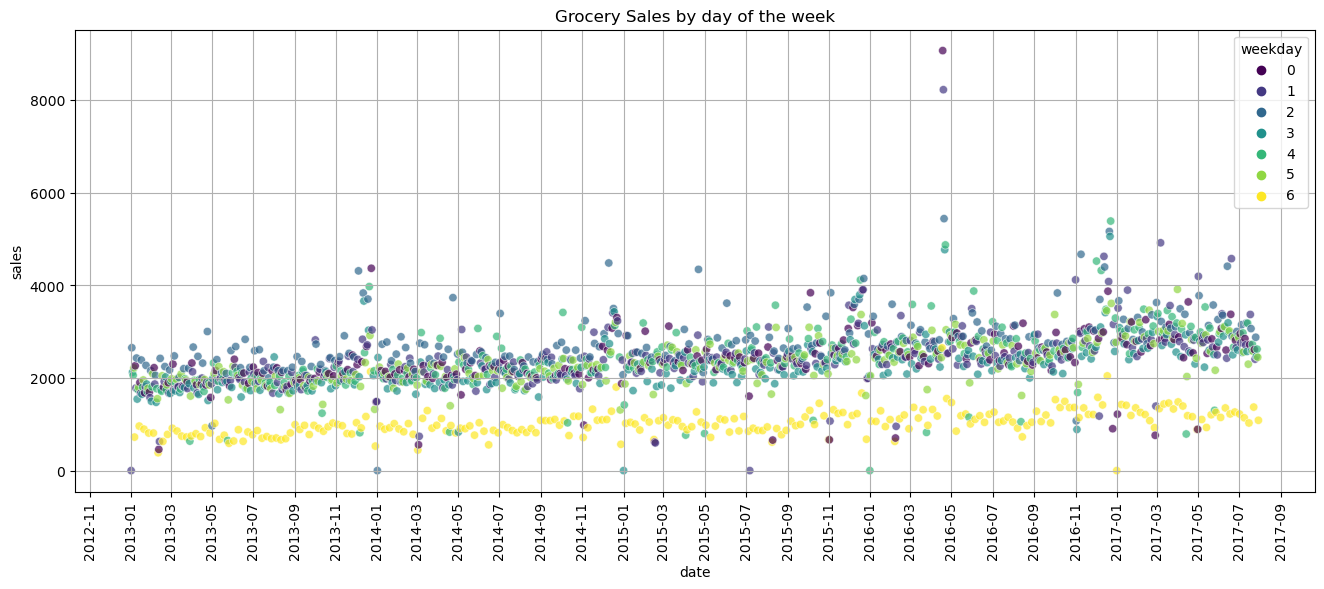

In [170]:
plt.figure(figsize=(16, 6))
sns.scatterplot(g, x='date', y='sales', hue='weekday', palette='viridis', alpha=0.7)
plt.title('Grocery Sales by day of the week')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [188]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

def plot_joint_plot(verif, x='yhat', y='y', title=None): 
    """
    
    Parameters
    ---------- 
    verif : pandas.DataFrame 
    x : string 
        The variable on the x-axis
        Defaults to `yhat`, i.e. the forecast or estimated values.
    y : string 
        The variable on the y-axis
        Defaults to `y`, i.e. the observed values
    title : string 
        The title of the figure, default `None`. 

 
    Returns
    -------
    f : matplotlib Figure object
    """

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", color="0.1")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]

    ax.text(0.05, 0.05,
            "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,[x,y]].corr().iloc[0,1],
                                                 MAE(verif.loc[:,y].values, verif.loc[:,x].values)),
            fontsize=16)

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    
    return g

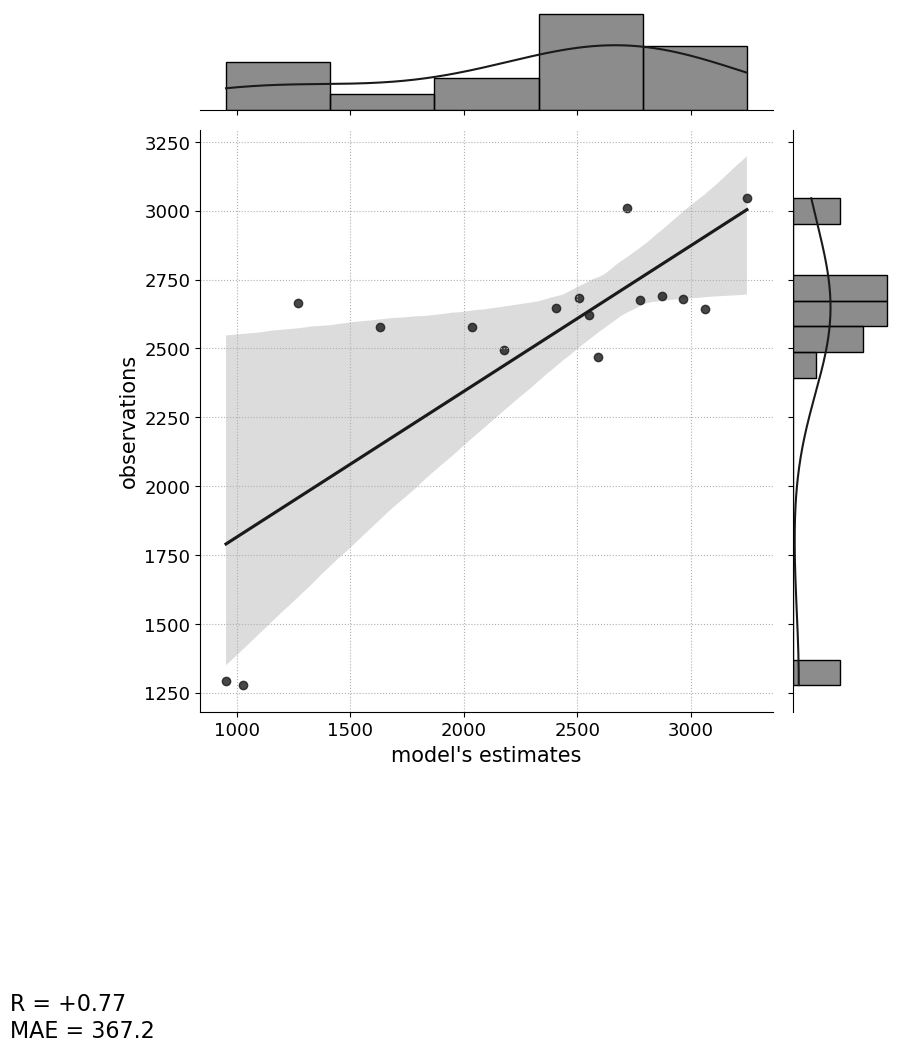

In [189]:
plot_joint_plot(val_df, x='y', y='yhat')

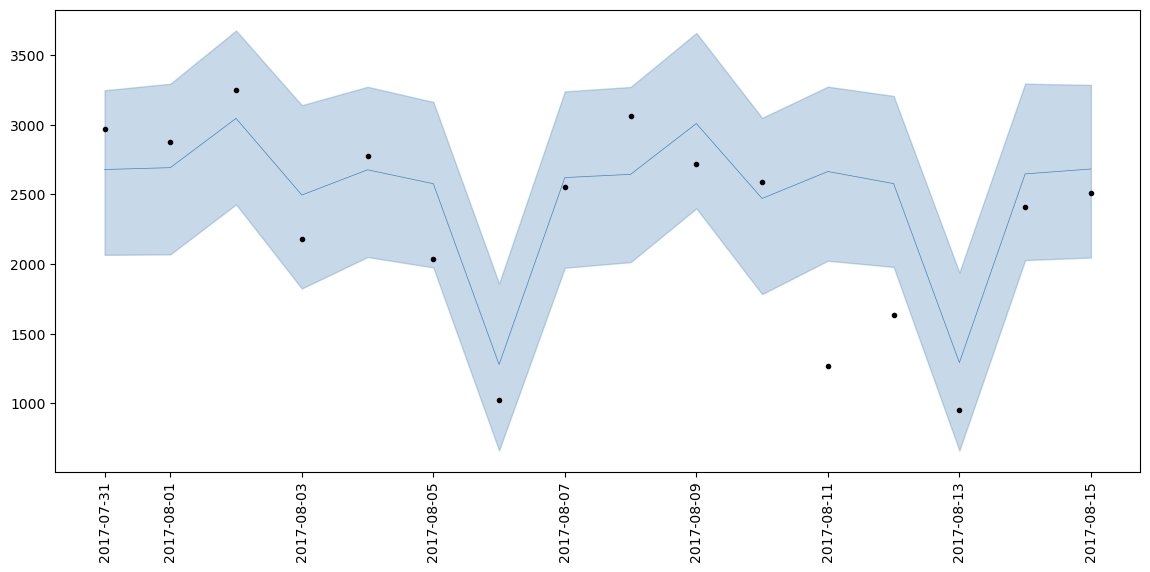

In [164]:
f, ax = plt.subplots(figsize=(14, 6))

ax.plot(val_df.ds, val_df.y, 'ko', markersize=3)

ax.plot(val_df.ds, val_df.yhat, color='steelblue', lw=0.5)

ax.fill_between(val_df.ds, val_df.yhat_lower, val_df.yhat_upper, color='steelblue', alpha=0.3)
plt.xticks(rotation=90)
plt.show()

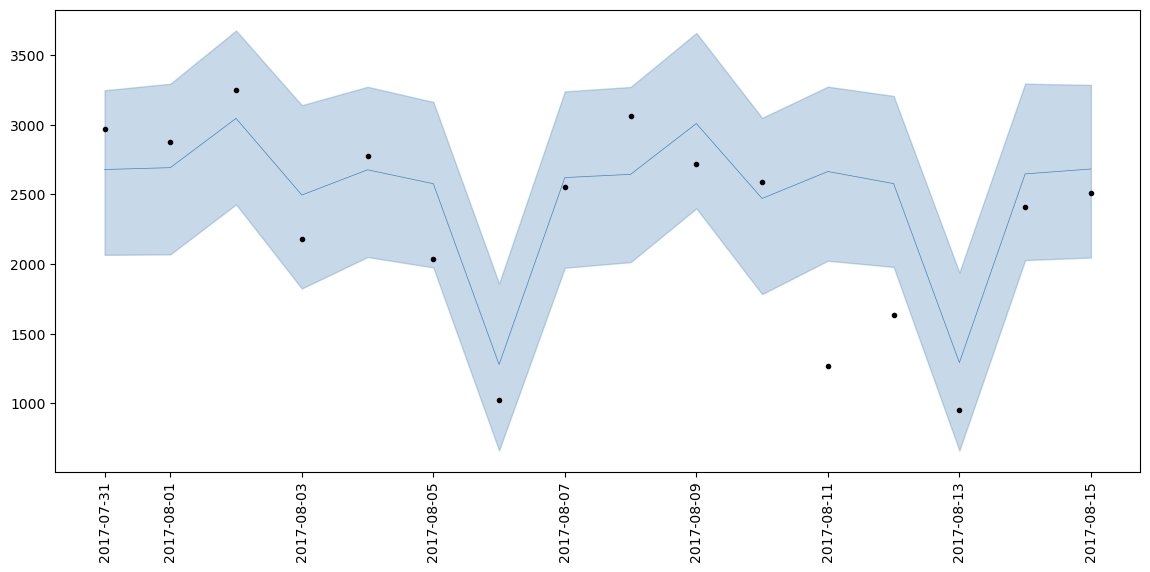

In [164]:
f, ax = plt.subplots(figsize=(14, 6))

ax.plot(val_df.ds, val_df.y, 'ko', markersize=3)

ax.plot(val_df.ds, val_df.yhat, color='steelblue', lw=0.5)

ax.fill_between(val_df.ds, val_df.yhat_lower, val_df.yhat_upper, color='steelblue', alpha=0.3)
plt.xticks(rotation=90)
plt.show()

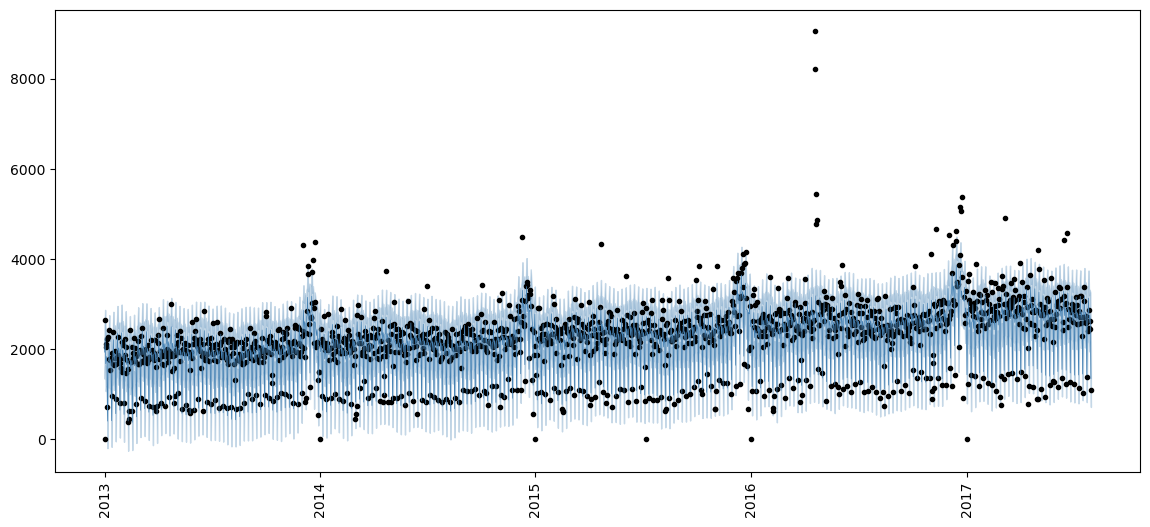

In [ ]:
aux = train_df.merge(m.predict(train_df), on='ds')

f, ax = plt.subplots(figsize=(14, 6))

ax.plot(aux.ds, aux.y, 'ko', markersize=3)

ax.plot(aux.ds, aux.yhat, color='steelblue', lw=0.5)

ax.fill_between(aux.ds, aux.yhat_lower, aux.yhat_upper, color='steelblue', alpha=0.3)
plt.xticks(rotation=90)
plt.show()

In [173]:
RMSLE(aux.y, aux.yhat)

0.5117789513206967

# Replace GROCERY I data on our Baseline model

In [235]:
filename = os.path.join(DATA_FOLDER, 'predictions/baseline_14D.csv')
dtype_map = {'id':str, 'sales':float}

baseline_df = pd.read_csv(filename, dtype=dtype_map)
print(baseline_df.shape)
baseline_df.head()

(28512, 2)


,id,sales
0,3000888,7.0
1,3000889,0.0
2,3000890,3.0
3,3000891,2369.0
4,3000892,0.0


In [241]:
new_pred = baseline_df[~baseline_df.id.isin(pred_df.id)]
new_pred = pd.concat([new_pred, pred_df[['id', 'sales']]])
new_pred.shape

(28512, 2)

In [242]:
# and store our predictions dataframe
pred_file = os.path.join(DATA_FOLDER, 'predictions/baseline_14D-ProphetGroceryI.csv')
formatted_pred = new_pred.copy()
formatted_pred.to_csv(path_or_buf=pred_file, index=False)